In [293]:
import YouTube_Data_Story as ds
import YouTube_Data_Wrangling as dw
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import holidays
import datetime

In [294]:
df_combined_usa_mx=dw.combined_usa_mx_df

In [295]:
df_views=df_combined_usa_mx.views
df_likes=df_combined_usa_mx.likes
df_dlikes=df_combined_usa_mx.dislikes
df_cc=df_combined_usa_mx.comment_count

#df for logs of views/likes/dlikes/cc.

df_dlikes_log=np.log(df_dlikes.where(df_dlikes > 0, np.median(df_dlikes)))
df_likes_log=np.log(df_likes.where(df_likes > 0, np.median(df_likes)))
df_cc_log=np.log(df_cc.where(df_cc > 0, np.median(df_cc)))
df_views_log=np.log(df_views.where(df_views > 0, np.median(df_views)))

#df_corr - to find corr between likes/dlikes/cc/views
df_corr_4=df_combined_usa_mx[['likes','dislikes','comment_count']]

#df_log - to create 3D plot

df_log=pd.DataFrame()
df_log.insert(0, column='views_log', value=df_views_log)
df_log.insert(1, column='likes_log', value=df_likes_log)
df_log.insert(2, column='dlikes_log', value=df_dlikes_log)
df_log.insert(3, column='cc_log', value=df_cc_log)



In [296]:
#Functions

def histograming(ax,df,title, xlabel):
    ax.hist(df, bins=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")
    
def graph3D(ax, x, y, z, classifier, x_label, y_label, z_label, title):
    sp = ax.scatter(x,y,z, s=30, c=classifier)
    #plt.colorbar(sp)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))   

def graph3Dlog(ax, x, y, z, classifier, x_label, y_label, z_label, title):
    sp = ax.scatter(x,y,z, s=30, c=classifier)
    #plt.colorbar(sp)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    #ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M')) 

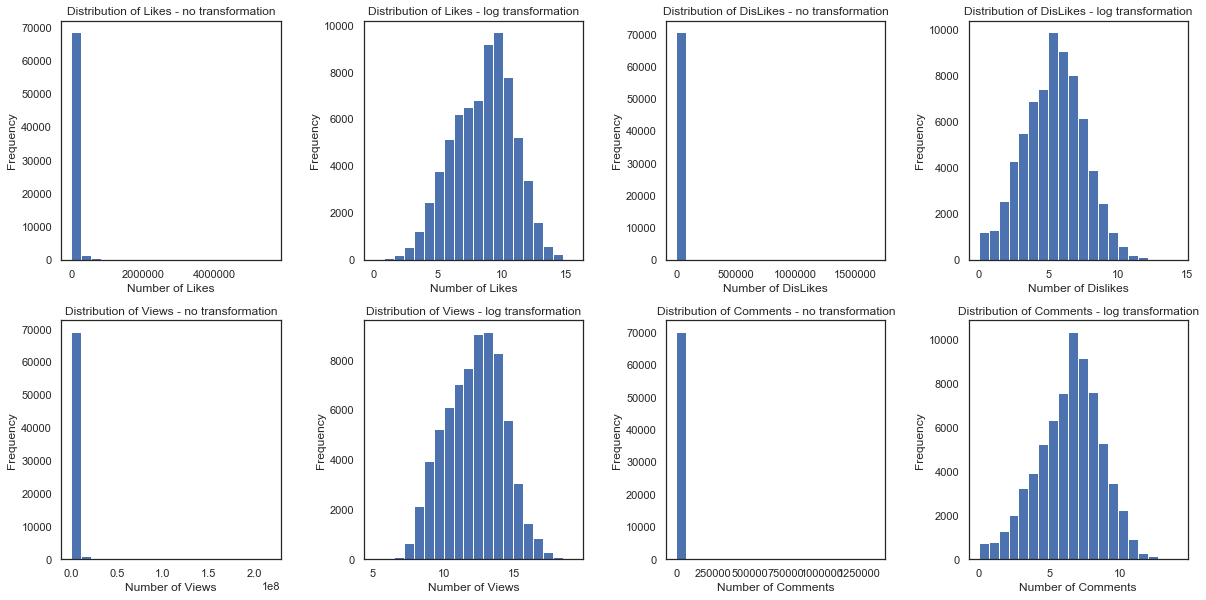

In [297]:
#Log Transforming likes/dislikes/views/cc so that the distributions are not skewed.

fig, ax =plt.subplots(2,4)
fig.set_size_inches(17, 8.5, forward=True)

histograming(ax[0,0],df_likes,"Distribution of Likes - no transformation", "Number of Likes") 
histograming(ax[0,1],df_likes_log,"Distribution of Likes - log transformation", "Number of Likes" )
histograming(ax[0,2],df_dlikes,"Distribution of DisLikes - no transformation", "Number of DisLikes" )
histograming(ax[0,3],df_dlikes_log,"Distribution of DisLikes - log transformation", "Number of Dislikes" )

histograming(ax[1,0],df_views,"Distribution of Views - no transformation", "Number of Views")
histograming(ax[1,1],df_views_log,"Distribution of Views - log transformation", "Number of Views" )
histograming(ax[1,2],df_cc,"Distribution of Comments - no transformation", "Number of Comments" )
histograming(ax[1,3],df_cc_log,"Distribution of Comments - log transformation", "Number of Comments" )
plt.tight_layout()

#### After log transformation views, likes, dislikes and cc are normally distributed. 

In [298]:
#Correlation between views, likes, dislikes and cc. 

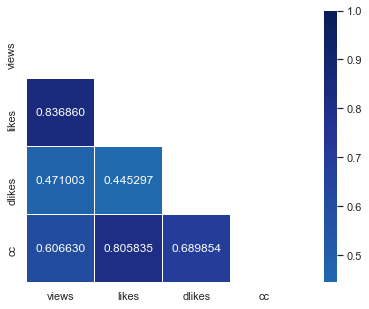

In [299]:
import seaborn as sns
sns.set(style="white")
# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,5))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap='YlGnBu',   center=0,
            square=True, linewidths=.5, annot=True, fmt="f")

#### None of the correlations are "strong enough". likes/views and likes/cc are more than 80% correlated. However I dont see that a person who views a video will definitly give "like" to it or "comment on it". The correlation exists but not causation. 
Based on this I will try following

1. I would check if elbow method shows any optimal number of clusters. fit_predict Kmeans clusters based on optimal k

2. TBD 

In [300]:
#KMeans elbow method to check for optimal K
inertia = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_corr)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

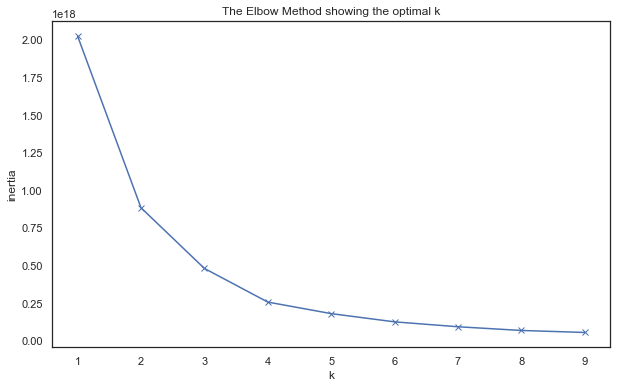

In [301]:
plt.figure(figsize=(10,6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

In [302]:
#from above elbow plot I can see that optimal K could be 3 or 4. Taking kmeans for both. 
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(df_corr)
pop_class3=kmeans3.predict(df_corr)

kmeans4 = KMeans(n_clusters=4, random_state=0).fit(df_corr)
pop_class4=kmeans4.predict(df_corr)

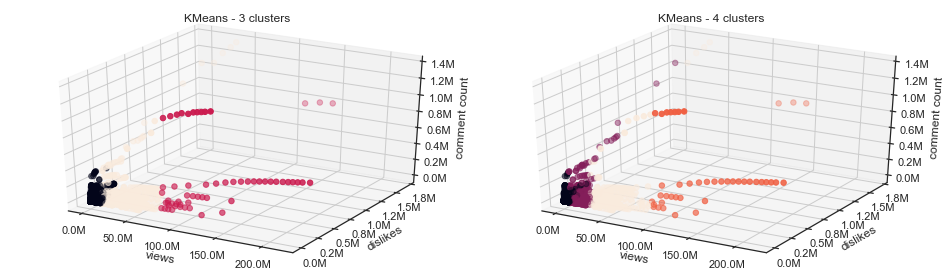

In [303]:
fig = plt.figure(figsize=plt.figaspect(0.3)) ## set up a figure twice as wide as it is tall
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

graph3D(ax1, df_corr['views'], df_corr['dlikes'], df_corr['cc'], pop_class3, "views", "dislikes", "comment count", "KMeans - 3 clusters")
graph3D(ax2, df_corr['views'], df_corr['dlikes'], df_corr['cc'], pop_class4, "views", "dislikes", "comment count", "KMeans - 4 clusters")

plt.tight_layout()

In [304]:
#We can clearly see at that at K=3 or 4 the inertia no longer decrease at a rate that it decreased from K=1 and K=2. 
#Optimal K could be 3 or 4. 

#I can now plot the same graph but for transformed data of likes/dislikes/cc/views. 
# It will give better pic of how many clusters I should use

In [283]:
kmeans3_log = KMeans(n_clusters=3, random_state=0).fit_predict(df_log)
kmeans4_log = KMeans(n_clusters=4, random_state=0).fit_predict(df_log)

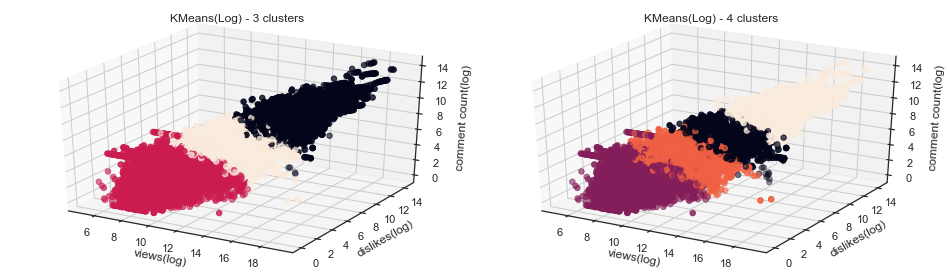

In [284]:
fig = plt.figure(figsize=plt.figaspect(0.3)) ## set up a figure twice as wide as it is tall
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

graph3Dlog(ax1, df_log['views_log'], df_log['dlikes_log'], df_log['cc_log'], kmeans3_log, "views(log)", "dislikes(log)", "comment count(log)", "KMeans(Log) - 3 clusters")
graph3Dlog(ax2, df_log['views_log'], df_log['dlikes_log'], df_log['cc_log'], kmeans4_log, "views(log)", "dislikes(log)", "comment count(log)", "KMeans(Log) - 4 clusters")

plt.tight_layout()

In [305]:
#optimal K after looking at clusters using transformed data = 4

In [306]:
df_combined_usa_mx.head()

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,pop_class
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,748374,57527,2966,15954,People & Blogs,USA,0
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,2418783,97185,6146,12703,Entertainment,USA,0
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,3191434,146033,5339,8181,Comedy,USA,0
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,343168,10172,666,2146,Entertainment,USA,0
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,2095731,132235,1989,17518,Entertainment,USA,0


In [289]:
df_combined_usa_mx.drop(['pop_class'], axis=1, inplace=True)

In [291]:
df_combined_usa_mx.head()

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,748374,57527,2966,15954,People & Blogs,USA
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,2418783,97185,6146,12703,Entertainment,USA
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,3191434,146033,5339,8181,Comedy,USA
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,343168,10172,666,2146,Entertainment,USA
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,2095731,132235,1989,17518,Entertainment,USA


In [292]:
df_combined_usa_mx.insert(10, column='pop_class', value=pop_class4)

In [91]:
df_combined_usa_mx.drop(['comments_disabled','ratings_disabled','video_error_or_removed'], axis=1, inplace=True)

In [93]:
df_classification=df_combined_usa_mx.drop(['views','likes','dislikes','comment_count'], axis=1)

In [95]:
df_classification.head()

,trending_date,title,category_id,publish_time,category_name,country,pop_class
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,People & Blogs,USA,0
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,Entertainment,USA,0
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,Comedy,USA,0
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,Entertainment,USA,0
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,Entertainment,USA,0


In [98]:
df_classification['publish_year']=df_classification['publish_time'].dt.year
df_classification['publish_day']=df_classification['publish_time'].dt.day
df_classification['publish_mon']=df_classification['publish_time'].dt.month

In [259]:
df_classification.drop(['holiday'], axis=1, inplace=True)

In [214]:


us_holiday=[]
for date in holidays.UnitedStates(years=2018).items():
    us_holiday.append(str(date[0]).split()[0])


for date in holidays.UnitedStates(years=2017).items():
    us_holiday.append(str(date[0]).split()[0])
    
df_us_hol=pd.DataFrame()
df_us_hol.insert(0,column='holiday', value=us_holiday)

In [234]:
holidays=holidays.US()

AttributeError: 'UnitedStates' object has no attribute 'US'

In [230]:
trending_date=df_classification[['trending_date','country']]

In [242]:
import holidays
from datetime import date

In [253]:
us_holidays=holidays.UnitedStates()

for publish_time in df_classification['publish_time']:
    if publish_time != us_holidays:
        df_classification['holiday']=0
    else:
        df_classification['holiday']=1

In [257]:
us_holidays

{}

In [254]:
df_classification.holiday.unique()

array([0], dtype=int64)

Text(0, 0.5, 'Log Likes')

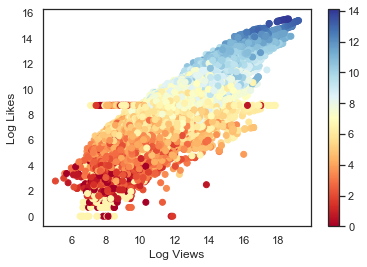

In [244]:
sc=plt.scatter(df['Log_views'],df['Log_likes'], c=df['Log_cc'], cmap='RdYlBu')
plt.colorbar(sc)
plt.xlabel("Log Views")
plt.ylabel("Log Likes")

Text(0, 0.5, 'Log DisLikes')

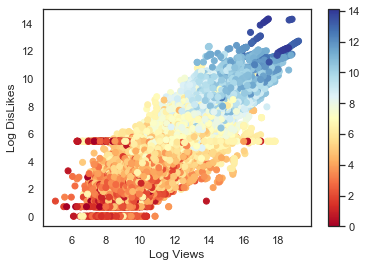

In [303]:
sc=plt.scatter(df['Log_views'],df['Log_dlikes'], c=df['Log_cc'], cmap='RdYlBu')
plt.colorbar(sc)
plt.xlabel("Log Views")
plt.ylabel("Log DisLikes")

In [300]:
df_combined_usa_mx.title.nunique()

35150

In [301]:
df_usa.title.nunique()

6083

In [302]:
df_mx.title.nunique()

29530

In [321]:
temp_df_views_usa=df_usa.groupby(['title'])['views'].max()

In [323]:
temp_df_views_usa.sort_values().count()

6083

In [351]:
df_combined_usa_mx['likes_rate']=df_combined_usa_mx['likes']/df_combined_usa_mx['views']

In [350]:
df_combined_usa_mx['dlikes_rate']=df_combined_usa_mx['dislikes']/df_combined_usa_mx['views']

In [352]:
df_combined_usa_mx['cc_rate']=df_combined_usa_mx['comment_count']/df_combined_usa_mx['views']

In [353]:
df_combined_usa_mx.likes_rate.max()

5.1009933774834435

In [354]:
df_combined_usa_mx.dlikes_rate.max()

0.4225865209471767

In [355]:
df_combined_usa_mx.cc_rate.max()

0.3843351548269581

In [356]:
df_rates=df_combined_usa_mx.drop(['comments_disabled','ratings_disabled','video_error_or_removed'], axis=1)

In [361]:
df_rates['dlikes_rate_log']=np.log(df_rates.dlikes_rate.where(df_rates.dlikes_rate > 0, np.median(df_rates.dlikes_rate)))
df_rates['likes_rate_log']=np.log(df_rates.likes_rate.where(df_rates.likes_rate > 0, np.median(df_rates.likes_rate)))
df_rates['cc_rate_log']=np.log(df_rates.cc_rate.where(df_rates.cc_rate > 0, np.median(df_rates.cc_rate)))


In [362]:
df_rates.head()

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,likes_rate,dlikes_rate,cc_rate,dlikes_rate_log,likes_rate_log,cc_rate_log
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,748374,57527,2966,15954,People & Blogs,USA,0.1,0.0,0.0,-5.5,-2.6,-3.8
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,2418783,97185,6146,12703,Entertainment,USA,0.0,0.0,0.0,-6.0,-3.2,-5.2
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,3191434,146033,5339,8181,Comedy,USA,0.0,0.0,0.0,-6.4,-3.1,-6.0
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,343168,10172,666,2146,Entertainment,USA,0.0,0.0,0.0,-6.2,-3.5,-5.1
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,2095731,132235,1989,17518,Entertainment,USA,0.1,0.0,0.0,-7.0,-2.8,-4.8


Text(0, 0.5, 'DisLikes Rate')

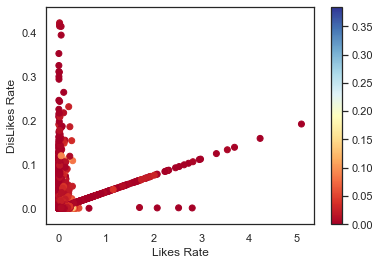

In [365]:
sc=plt.scatter(df_rates['likes_rate'],df_rates['dlikes_rate'], c=df_rates['cc_rate'], cmap='RdYlBu')
plt.colorbar(sc)
plt.xlabel("Likes Rate")
plt.ylabel("DisLikes Rate")

Text(0, 0.5, 'Log DisLikes Rate')

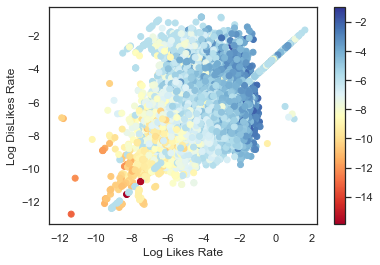

In [366]:
sc=plt.scatter(df_rates['likes_rate_log'],df_rates['dlikes_rate_log'], c=df_rates['cc_rate_log'], cmap='RdYlBu')
plt.colorbar(sc)
plt.xlabel("Log Likes Rate")
plt.ylabel("Log DisLikes Rate")

In [372]:
df_rates_kmeans=df_rates[['likes_rate_log','dlikes_rate_log','cc_rate_log']]

In [374]:
kmeans_rate3 = KMeans(n_clusters=3, random_state=0).fit_predict(df_rates_kmeans)

Text(0.5, 0.92, 'KMeans - 3 clusters, Log of rates')

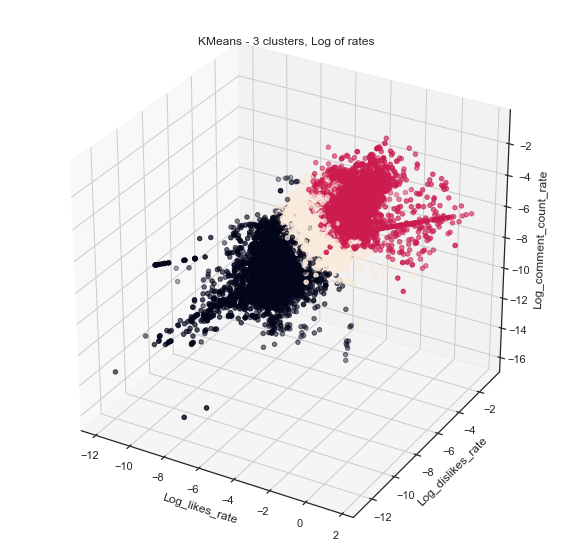

In [375]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

sp = ax.scatter(df_rates_kmeans['likes_rate_log'],df_rates_kmeans['dlikes_rate_log'],df_rates_kmeans['cc_rate_log'], s=20, c=kmeans_rate3)
#plt.colorbar(sp)
ax.set_xlabel("Log_likes_rate")
ax.set_ylabel("Log_dislikes_rate")
ax.set_zlabel("Log_comment_count_rate")
ax.set_title("KMeans - 3 clusters, Log of rates")

In [455]:
kmeans_fit= KMeans(n_clusters=5, random_state=0).fit(df_rates_kmeans)
kmeans_rate5=kmeans_fit.predict(df_rates_kmeans)
kmeans_fit.labels_

array([0, 4, 4, ..., 4, 3, 0])

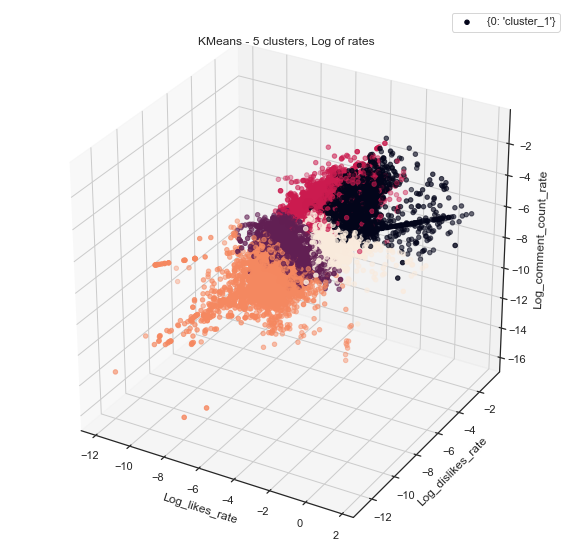

In [471]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

sp = ax.scatter(df_rates_kmeans['likes_rate_log'],df_rates_kmeans['dlikes_rate_log'],df_rates_kmeans['cc_rate_log'], s=20, c=kmeans_rate5, marker='o', label=lambda x: if kmeans_rate5==0:'cluster_0'})
#plt.colorbar(sp)
ax.set_xlabel("Log_likes_rate")
ax.set_ylabel("Log_dislikes_rate")
ax.set_zlabel("Log_comment_count_rate")
ax.set_title("KMeans - 5 clusters, Log of rates")
plt.legend(numpoints=1)

In [382]:
df_rates['Popularity_Class']=kmeans_rate5

In [383]:
df_rates.head()

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,likes_rate,dlikes_rate,cc_rate,dlikes_rate_log,likes_rate_log,cc_rate_log,Popularity_Class
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,748374,57527,2966,15954,People & Blogs,USA,0.1,0.0,0.0,-5.5,-2.6,-3.8,0
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,2418783,97185,6146,12703,Entertainment,USA,0.0,0.0,0.0,-6.0,-3.2,-5.2,4
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,3191434,146033,5339,8181,Comedy,USA,0.0,0.0,0.0,-6.4,-3.1,-6.0,4
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,343168,10172,666,2146,Entertainment,USA,0.0,0.0,0.0,-6.2,-3.5,-5.1,4
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,2095731,132235,1989,17518,Entertainment,USA,0.1,0.0,0.0,-7.0,-2.8,-4.8,0


In [386]:
df_rates.views.max(), df_rates.views.min()

(217750076, 157)

In [385]:
df_rates[df_rates.views==217750076]

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,likes_rate,dlikes_rate,cc_rate,dlikes_rate_log,likes_rate_log,cc_rate_log,Popularity_Class
38098,2018-05-31,Childish Gambino - This Is America (Official V...,10,2018-05-06,217750076,4934188,335462,509799,Music,USA,0.0,0.0,0.0,-6.5,-3.8,-6.1,4


In [387]:
df_rates[df_rates.views==157]

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,likes_rate,dlikes_rate,cc_rate,dlikes_rate_log,likes_rate_log,cc_rate_log,Popularity_Class
43430,2017-11-26,RESUMEN CELAYA VS ALEBRIJES ASCENSO MX 2017,17,2017-11-26,157,16,3,7,Sports,Mexico,0.1,0.0,0.0,-4.0,-2.3,-3.1,0


In [388]:
df_rates.groupby(['Popularity_Class'])['title'].count()

Popularity_Class
0    15322
1    18004
2     7178
3     6042
4    24249
Name: title, dtype: int64

| Class | Popular      |  likes_rate, dislikes_rate,cc_rate   | Number of Likes, Dislikes, Comment_Count|
|------|---------------|--------------------------------------|-----------------------------------------|
|   0  | Not Popular   | (0-5.1), (0-0.2), (0-0.4)            | (10-5595203), (1-629120), (0-1225326)
|------|---------------|--------------------------------------|-----------------------------------------|
|   1  | Kinda Popular | (0-0.1),(0-0),(0-0)                  | (1-3094021), (1-129502), (0-242039)
|------|---------------|--------------------------------------|-----------------------------------------|
|   2  | Popular       |  (0-0.2), (0-0.4), (0-0.1)           | (1-3093544), (2-1674420), (0-1361580)
|------|---------------|--------------------------------------|-----------------------------------------|
|   3  | Highly Popular|  (0-0.1), (0-0), (0-0)               | (1-1427436), (1-71494), (0-55320)
|------|---------------|--------------------------------------|-----------------------------------------|
|   4  | Most Popular  |  (0-2.5),(0-0), (0-0)                | (21-4934188), (1-335462), (0-509799)    |

In [409]:
df_rates.loc[df_rates.Popularity_Class==0].min() #Class0 = 0-5.1, 0-0.2, 0,0.4, Class1 = 0-0.1,0-0,0-0, Class2 = 0-0.2, 0-0.4, 0-0.1, Class3=0-0.1, 0-0, 0-0, Class4=0-2.5,0-0, 0-0  

trending_date                                     2017-11-14 00:00:00
title               !! THIS VIDEO IS NOTHING BUT PAIN !! | Getting...
category_id                                                         1
publish_time                                      2016-10-14 00:00:00
views                                                             157
likes                                                              10
dislikes                                                            1
comment_count                                                       0
category_name                                        Autos & Vehicles
country                                                        Mexico
likes_rate                                                        0.0
dlikes_rate                                                       0.0
cc_rate                                                           0.0
dlikes_rate_log                                                  -9.3
likes_rate_log      

In [413]:
df_rates.loc[df_rates.Popularity_Class==4].max() #Class4= 21-4934188, 1-335462, 0-509799, Class3= 1-1427436, 1-71494, 0-55320, Class2=1-3093544, 2-1674420, 0-1361580, Class1=1-3094021, 1-129502, 0-242039, Class0=10-5595203, 1-629120, 0-1225326 

trending_date                      2018-12-06 00:00:00
title               🎃 How to make Pumpkin Pie Mistakes
category_id                                         43
publish_time                       2018-06-14 00:00:00
views                                        217750076
likes                                          4934188
dislikes                                        335462
comment_count                                   509799
category_name                          Travel & Events
country                                            USA
likes_rate                                         2.5
dlikes_rate                                        0.0
cc_rate                                            0.0
dlikes_rate_log                                   -3.2
likes_rate_log                                     0.9
cc_rate_log                                       -3.8
Popularity_Class                                     4
dtype: object

In [417]:
df_rates[df_rates['views']==df_rates['views'].max()]

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,likes_rate,dlikes_rate,cc_rate,dlikes_rate_log,likes_rate_log,cc_rate_log,Popularity_Class
38098,2018-05-31,Childish Gambino - This Is America (Official V...,10,2018-05-06,217750076,4934188,335462,509799,Music,USA,0.0,0.0,0.0,-6.5,-3.8,-6.1,4


In [479]:
import mglearn
kmeans_rate_new=KMeans(n_clusters=3, random_state=0).fit(df_rates_kmeans)

In [480]:
kmeans_rate_new.cluster_centers_

array([[-5.18709988, -7.51309719, -7.28936416],
       [-2.60135926, -6.2506847 , -4.5696022 ],
       [-3.7359795 , -6.81975728, -5.88794148]])

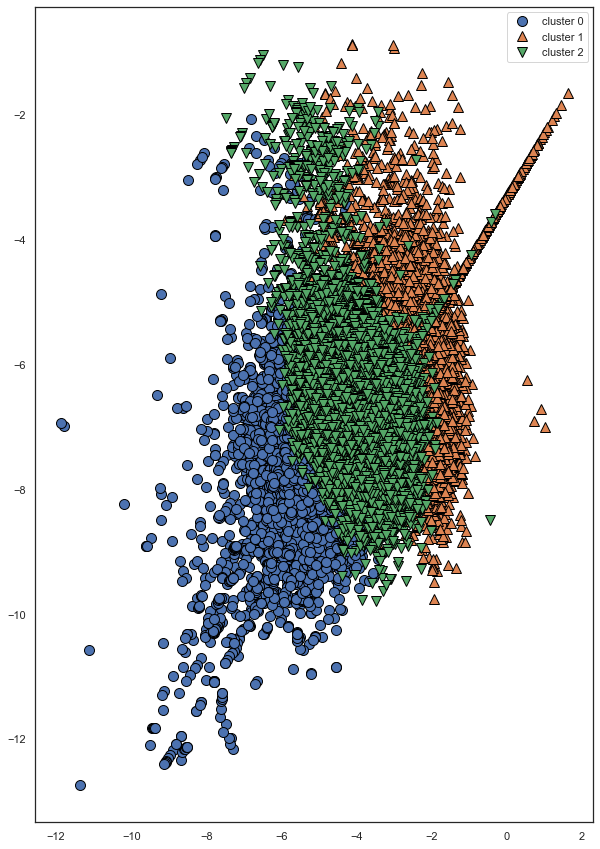

In [481]:
fig, axes =plt.subplots(figsize=(10,15))
mglearn.discrete_scatter(df_rates_kmeans['likes_rate_log'],df_rates_kmeans['dlikes_rate_log'],kmeans_rate_new.labels_)
#mglearn.discrete_scatter(kmeans_rate_new.cluster_centers_[:,0],kmeans_rate_new.cluster_centers_[:,1],kmeans_rate_new.cluster_centers_[:,2],kmeans_rate_new.cluster_centers_[:,3],kmeans_rate_new.cluster_centers_[:,4],[0,1,2,3,4])
plt.legend(['cluster 0', 'cluster 1', 'cluster 2'], loc='best')


In [515]:
temp=df_rates.groupby(['title','country']).mean()

In [540]:
temp.head()

,,views,likes,dislikes,comment_count,Popularity_Class
title,country,,,,,
Es admirable que Shani haya tenido agallas para retarme FABY APACHE,Mexico,"6,060.0",90.0,16.0,30.0,2.0
"Fantasma, no necesitabas traer a tus achichincles que nadie conoce OVETT",Mexico,"5,186.0",25.0,4.0,2.0,3.0
Me La JuguÃ© con Riesgo a Tronarme AsÃ­ HablÃ³ Lupita Gonzalez 1era BICAMPEONA DEL MUNDO EN MARCHA,Mexico,"9,573.0",77.0,1.0,17.0,1.0
PEDRO INFANTE ERA CHAPARRITO - ISMAEL RODRIGUEZ,Mexico,"11,137.0",122.0,15.0,33.0,1.0
! PERO QUÃ‰ VALOR EL DE ESTE MAESTRO!ðŸ˜®ðŸ˜®ðŸ˜®,Mexico,"199,756.0","2,116.0",331.5,558.0,1.0


In [517]:
temp=temp.drop(['category_id','likes_rate','dlikes_rate','cc_rate','dlikes_rate_log','likes_rate_log','cc_rate_log'], axis=1)

In [531]:
import math
temp.Popularity_Class=np.ceil(temp.Popularity_Class)

In [533]:
temp[temp.views==144034186.91304347] #max views

,,views,likes,dislikes,comment_count,Popularity_Class
title,country,,,,,
Childish Gambino - This Is America (Official Video),USA,"144,034,186.9","3,770,215.9","233,599.5","396,596.5",4.0


In [534]:
temp[temp.likes==5093940.230769231] #max likes

,,views,likes,dislikes,comment_count,Popularity_Class
title,country,,,,,
BTS (방탄소년단) 'FAKE LOVE' Official MV,USA,"89,244,413.2","5,093,940.2","167,914.2","1,103,069.7",0.0


In [535]:
temp[temp.dislikes==1596819.0] #max dislikes

,,views,likes,dislikes,comment_count,Popularity_Class
title,country,,,,,
YouTube Rewind: The Shape of 2017 | #YouTubeRewind,USA,"137,550,494.7","3,006,905.7","1,596,819.0","811,946.0",2.0


In [536]:
temp[temp.comment_count==1170006.4285714286] #max comment_count

,,views,likes,dislikes,comment_count,Popularity_Class
title,country,,,,,
So Sorry.,USA,"29,185,529.4","1,213,676.1","1,313,219.9","1,170,006.4",2.0


In [538]:
temp.groupby(['Popularity_Class']).count()

,views,likes,dislikes,comment_count
Popularity_Class,,,,
0.0,9894,9894,9894,9894
1.0,8419,8419,8419,8419
2.0,4048,4048,4048,4048
3.0,4499,4499,4499,4499
4.0,8753,8753,8753,8753


In [ ]:
# From above counts I can see that most of the videos are placed in highly popular or almost no popularity. The middle classes of popularity
# are small in numbers


In [541]:
temp_genre=df_rates.groupby(['category_name','country']).mean()

In [543]:
temp_genre.head()

category_id       views    likes  dislikes  \
category_name    country                                               
Autos & Vehicles Mexico           2.0   202,436.6 12,278.6     352.4   
                 USA              2.0 1,403,359.4 10,520.2     633.7   
Comedy           Mexico          23.0   429,927.8 29,925.7   1,394.4   
                 USA             23.0 1,487,374.1 62,646.0   2,120.1   
Education        Mexico          27.0    88,796.1  5,479.5     147.4   

                          comment_count  likes_rate  dlikes_rate  cc_rate  \
category_name    country                                                    
Autos & Vehicles Mexico         1,533.6         0.1          0.0      0.0   
                 USA            1,920.4         0.0          0.0      0.0   
Comedy           Mexico         3,359.2         0.1          0.0      0.0   
                 USA            6,423.5         0.0          0.0      0.0   
Education        Mexico           616.0         0.1          0.0      0.0   

                          dlikes_rate_log  likes_rate_log  cc_rate_log  \
category_name    country                                                 
Autos & Vehicles Mexico              -6.6            -3.0         -5.0   
                 USA                 -7.3            -4.7         -6.4   
Comedy           Mexico              -6.5            -3.0         -5.3   
                 USA                 -6.8            -3.4         -5.8   
Education        Mexico              -6.5            -2.9         -5.2   

                          Popularity_Class  
category_name    country                    
Autos & Vehicles Mexico                1.7  
                 USA                   2.7  
Comedy           Mexico                1.7  
                 USA                   2.3  
Education        Mexico                1.3

In [544]:
temp_genre=temp_genre.drop(['category_id','likes_rate','dlikes_rate','cc_rate','dlikes_rate_log','likes_rate_log','cc_rate_log'], axis=1)

In [548]:
temp_genre.head()

views    likes  dislikes  comment_count  \
category_name    country                                                 
Autos & Vehicles Mexico    202,436.6 12,278.6     352.4        1,533.6   
                 USA     1,403,359.4 10,520.2     633.7        1,920.4   
Comedy           Mexico    429,927.8 29,925.7   1,394.4        3,359.2   
                 USA     1,487,374.1 62,646.0   2,120.1        6,423.5   
Education        Mexico     88,796.1  5,479.5     147.4          616.0   

                          Popularity_Class  
category_name    country                    
Autos & Vehicles Mexico                2.0  
                 USA                   3.0  
Comedy           Mexico                2.0  
                 USA                   3.0  
Education        Mexico                2.0

In [546]:
import math
temp_genre.Popularity_Class=np.ceil(temp_genre.Popularity_Class)

In [547]:
temp_genre.head()

views    likes  dislikes  comment_count  \
category_name    country                                                 
Autos & Vehicles Mexico    202,436.6 12,278.6     352.4        1,533.6   
                 USA     1,403,359.4 10,520.2     633.7        1,920.4   
Comedy           Mexico    429,927.8 29,925.7   1,394.4        3,359.2   
                 USA     1,487,374.1 62,646.0   2,120.1        6,423.5   
Education        Mexico     88,796.1  5,479.5     147.4          616.0   

                          Popularity_Class  
category_name    country                    
Autos & Vehicles Mexico                2.0  
                 USA                   3.0  
Comedy           Mexico                2.0  
                 USA                   3.0  
Education        Mexico                2.0

In [551]:
temp_genre

views     likes  dislikes  comment_count  \
category_name         country                                                  
Autos & Vehicles      Mexico    202,436.6  12,278.6     352.4        1,533.6   
                      USA     1,403,359.4  10,520.2     633.7        1,920.4   
Comedy                Mexico    429,927.8  29,925.7   1,394.4        3,359.2   
                      USA     1,487,374.1  62,646.0   2,120.1        6,423.5   
Education             Mexico     88,796.1   5,479.5     147.4          616.0   
                      USA       693,206.5  29,036.6     791.6        3,150.7   
Entertainment         Mexico    259,546.0  12,706.4     543.4        1,884.7   
                      USA     1,950,814.0  49,996.7   3,977.5        6,957.9   
Film & Animation      Mexico    381,098.6  14,756.0     413.6        1,657.9   
                      USA     3,070,582.6  70,457.0   2,655.2        7,735.2   
Gaming                Mexico    419,866.8  23,643.4     933.6        2,734.5   
                      USA     2,631,255.4  85,139.1  10,927.8       17,825.1   
Howto & Style         Mexico    178,506.8   9,424.2     306.9        1,307.8   
                      USA       913,463.2  37,940.3   1,227.4        5,412.3   
Music                 Mexico  1,225,594.6  64,907.2   2,353.4        6,117.7   
                      USA     6,269,235.5 220,413.4   8,093.1       19,752.3   
News & Politics       Mexico    161,667.2   3,972.6     327.5          767.9   
                      USA       580,867.9   6,959.3   1,655.1        2,395.3   
Nonprofits & Activism USA     3,116,187.7 278,051.1  61,133.5       90,178.7   
People & Blogs        Mexico    153,457.3   6,003.5     422.4          913.6   
                      USA     1,593,894.3  60,194.3   3,197.6        8,126.7   
Pets & Animals        Mexico    578,838.7  11,752.1     824.1        2,022.2   
                      USA       784,471.9  20,468.4     553.1        2,716.3   
Science & Technology  Mexico    421,694.3  10,357.6     564.8        1,785.9   
                      USA     1,438,492.1  33,503.4   1,893.3        4,833.0   
Shows                 Mexico     21,812.0     163.7      30.3          110.3   
                      USA       862,354.2  18,660.6     412.5        1,670.9   
Sports                Mexico    340,662.2   7,848.4     331.4          808.3   
                      USA     2,012,383.2  44,037.7   2,476.1        5,153.9   
Travel & Events       Mexico    135,334.9   7,799.3     223.8          908.4   
                      USA       873,882.5  11,725.0     868.9        2,185.9   

                               Popularity_Class  
category_name         country                    
Autos & Vehicles      Mexico                2.0  
                      USA                   3.0  
Comedy                Mexico                2.0  
                      USA                   3.0  
Education             Mexico                2.0  
                      USA                   4.0  
Entertainment         Mexico                2.0  
                      USA                   3.0  
Film & Animation      Mexico                2.0  
                      USA                   3.0  
Gaming                Mexico                2.0  
                      USA                   3.0  
Howto & Style         Mexico                2.0  
                      USA                   3.0  
Music                 Mexico                2.0  
                      USA                   3.0  
News & Politics       Mexico                2.0  
                      USA                   2.0  
Nonprofits & Activism USA                   3.0  
People & Blogs        Mexico                2.0  
                      USA                   3.0  
Pets & Animals        Mexico                2.0  
                      USA                   3.0  
Science & Technology  Mexico                2.0  
                      USA                   3.0  
Shows                 Mexico                2

In [552]:
df_rates.head()

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,likes_rate,dlikes_rate,cc_rate,dlikes_rate_log,likes_rate_log,cc_rate_log,Popularity_Class
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,748374,57527,2966,15954,People & Blogs,USA,0.1,0.0,0.0,-5.5,-2.6,-3.8,0
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,2418783,97185,6146,12703,Entertainment,USA,0.0,0.0,0.0,-6.0,-3.2,-5.2,4
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,3191434,146033,5339,8181,Comedy,USA,0.0,0.0,0.0,-6.4,-3.1,-6.0,4
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,343168,10172,666,2146,Entertainment,USA,0.0,0.0,0.0,-6.2,-3.5,-5.1,4
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,2095731,132235,1989,17518,Entertainment,USA,0.1,0.0,0.0,-7.0,-2.8,-4.8,0
